# Time Series Forecating Using ETS, ARIMA and LSTM

## Table of Contents

* [1. Time Series](#1)
* [2. Traing/Testing Data](#2)
* [3. Seasonality](#3)
* [4. Stationarity](#4)
* [5. ETS Model](#5)
* [6. ARIMA Model](#6)
* [7. LSTM Network](#7)
* [8. Model Comparison](#8)
* [9. References](#9)

According to the **NASA** (2017), Sunspots appear as dark spots on the surface of the Sun. They typically last for several days, although very large ones may live for several weeks. Sunspots are magnetic regions on the Sun with magnetic field strengths thousands of times stronger than the Earth's magnetic field. Sunspots usually come in groups with two sets of spots. One set will have positive or north magnetic field while the other set will have negative or south magnetic field. The field is strongest in the darker parts of the sunspots - the umbra. The field is weaker and more horizontal in the lighter part - the penumbra. 

This analysis will used sunspot area data as an example.

In [3]:
import statsmodels
import numpy as np 
import pandas as pd
import datetime 
from scipy import stats
import statsmodels

data = pd.read_csv("https://solarscience.msfc.nasa.gov/greenwch/sunspot_area.txt")
data[['Year', 'Month', 'Area']] = data[' Year Mon  Area'].str.split(expand=True)
data = data.drop(columns=' Year Mon  Area')
data

,Year,Month,Area
0,1874,5,365.1
1,1874,6,415.2
2,1874,7,1033.5
3,1874,8,954.1
4,1874,9,335.3
...,...,...,...
1704,2016,5,491.8
1705,2016,6,217.9
1706,2016,7,335.1
1707,2016,8,308.2


In [4]:
from statsmodels.tsa.base.datetools import dates_from_range
data = data.drop(columns=['Year', 'Month'])
data.index = (dates_from_range(start = "1874m5",
                               end = "2016m9"))
data.Area = data.Area.astype(float)
data

,Area
1874-05-31,365.1
1874-06-30,415.2
1874-07-31,1033.5
1874-08-31,954.1
1874-09-30,335.3
...,...
2016-05-31,491.8
2016-06-30,217.9
2016-07-31,335.1
2016-08-31,308.2


## 1. Time Series <a class="anchor" id="1"></a>
Plot the ts data

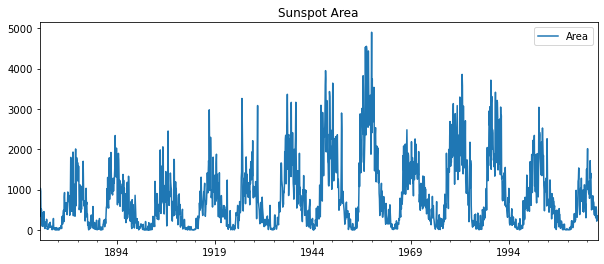

In [6]:
#plot the ts
import matplotlib.pyplot as plt
data.plot(figsize = (10, 4))
plt.title("Sunspot Area")
plt.show()

## 2. Train/Test Split <a class="anchor" id="2"></a>
I will spilit the data based on 70/30 like the plot below:

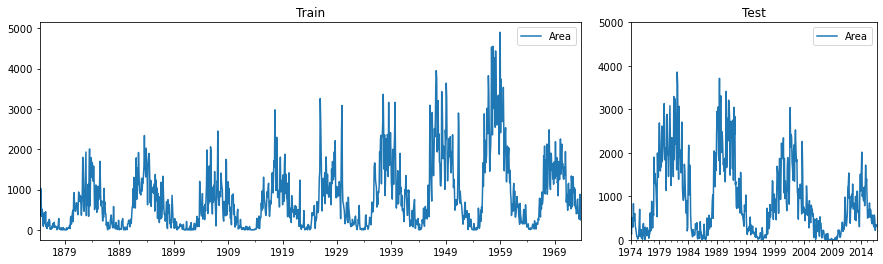

In [201]:
cut = round(len(data)*0.7)
train = data[:cut]
test = data[cut:]

data.plot(figsize = (15, 4))
grid = plt.GridSpec(1, 3, wspace=0.2, hspace=0.3)

ax1 = plt.subplot(grid[0, :2])
ax2= plt.subplot(grid[0, 2])

train.plot(ax = ax1, title = "Train")
test.plot(ax = ax2, title = "Test")
plt.ylim((0,5000))
plt.show()

## 2. Seasonality <a class="anchor" id="2"></a>

Understanding seasonability is very important prior to modeling process. A seasonal plot is similar to a time plot except that the data are plotted against the individual “seasons” in which the data were observed.

Through the season plots, it is not clear to see strong seasonality but Feburary and November are likely to have more sunspots than other months.

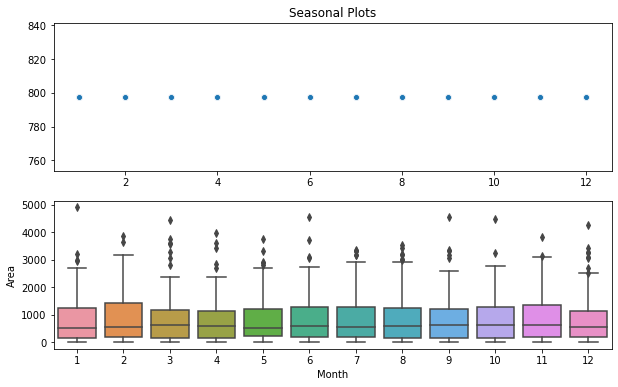

In [200]:
import seaborn as sns
plt.figure(figsize= (10,6))
ax = plt.subplot(211)

plt.title("Seasonal Plots")
sns.scatterplot(data = train, 
                x = train.index.month, 
                y = train.Area.mean(),
                #hue = train.index.year,
                ax = ax,
                legend = False)

ax2 = plt.subplot(212)
sns.boxplot(data = data,
            x = data.index.month, 
            y = data.Area,
            ax = ax2)
plt.xlabel("Month")
plt.show()

## 3. Stationarity <a class="anchor" id="3"></a>

According to **Kwiatkowski, D., Phillips, P. C. B., Schmidt, P., & Shin, Y.(1992)**,  stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time.

This data looks stationary. I could perform a `ADF` test together with `ACF/PACF` plots to justify my thoughts. ADF stands for augmented Dickey–Fuller test. This test could help gaining a understanding whether this time series are stationary or not.
- H<sub>0</sub> : The null hypothesis for this test is that there is a unit root.
- H<sub>1</sub> : The alternate hypothesis differs slightly according to which equation you’re using. The basic alternate is that the time series is stationary (or trend-stationary).

Since the test returns a p-value smaller than 0.05, I could reject the null hypothesis and accept alternative hypothesis saying that this series is **stationary**.

In [9]:
#adf tests
from statsmodels.tsa.stattools import adfuller

def ADF(ts):
    print("")
    print("###########################################")
    print("# Results of Augmented Dickey-Fuller Test #")
    print("###########################################", "\n")
    dftest = adfuller(ts[ts.columns[0]], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    print("___________________________________________", "\n")
    if dftest[1] <= 0.05:
        print("This Series is Stationary")
    else:
        print("This Series is Explosive")

ADF(train)


###########################################
# Results of Augmented Dickey-Fuller Test #
########################################### 

Test Statistic                   -5.499029
p-value                           0.000002
#Lags Used                       23.000000
Number of Observations Used    1172.000000
Critical Value (1%)              -3.435942
Critical Value (5%)              -2.864009
Critical Value (10%)             -2.568085
dtype: float64
___________________________________________ 

This Series is Stationary


**ACF** is an (complete) auto-correlation function which gives us values of auto-correlation of any series with its lagged values. We plot these values along with the confidence band and tada! We have an ACF plot. In simple terms, it describes how well the present value of the series is related with its past values. 

**PACF** is a partial auto-correlation function. Basically instead of finding correlations of present with lags like ACF, it finds correlation of the residuals (which remains after removing the effects which are already explained by the earlier lag(s)) with the next lag value hence ‘partial’ and not ‘complete’ as we remove already found variations before we find the next correlation. 

In this series, it is clearly that there is strong auto-correlation between present values and historical values. 

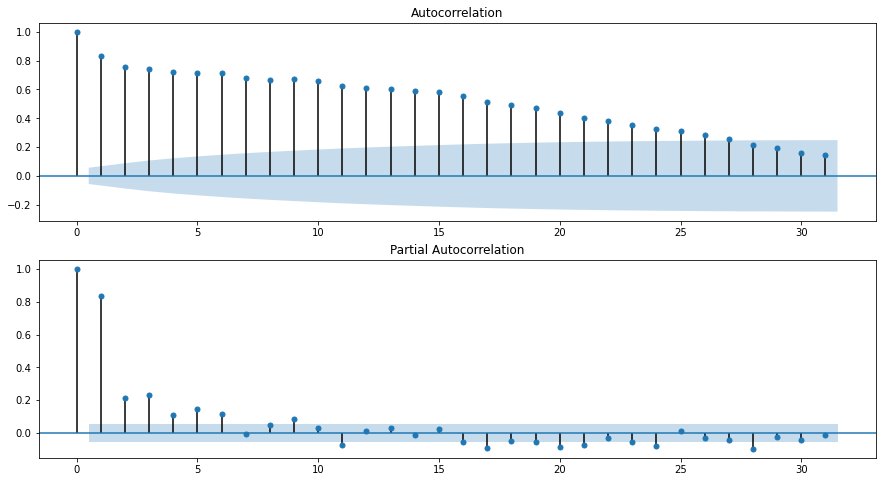

In [67]:
#ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
fig = plt.figure(figsize = (15, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(train.values.squeeze(), ax = ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(train,  ax=ax2)

## 5. ETS Model <a class="anchor" id="5"></a>

`ETS` stands for **error**, **trend**, **seasonality**. 

Before we pick a `ETS`  model, we want to understand the components of this data better. Time series decomposition is a preferred method to deal this. The equation of additive decompostion is below:

\begin{align}
Y(Observed) = Trend + Seasonal + Residual
\end{align}

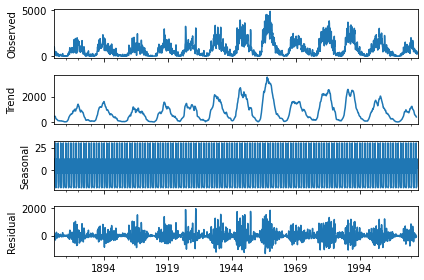

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')
seasonal_decompose(data, model="additive", freq=12).plot()
plt.show()

From the ETS decompostion, it suggests this sereis have 

In [79]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as ETS
#define RMSE metrics
def RMSE(y, y_pred):
    from sklearn.metrics import mean_squared_error
    from math import sqrt
    return round((sqrt(mean_squared_error(y, y_pred))), ndigits =2)

from datetime import datetime
start = datetime.now()
ETS = ETS(train, seasonal= 'add', trend = 'add', seasonal_periods = 12).fit()
ETS_pred = ETS.predict(start = len(train)+1, end = len(data))
print("RMSE:",RMSE(test, ETS_pred))
print("Modeling Process Took: ",datetime.now() - start)

RMSE: 1052.79
Modeling Process Took:  0:00:00.248902


## 6. ARIMA Model <a class="anchor" id="6"></a>

**ARIMA** stands for autoregressive integrated moving average model. This series has seasonality so that I am modeling seasonal ARIMA. The key paramters for Seasonal ARIMA are `(p,d,q)(P,D,Q)m`. Here m=12 since this is monthly data.

### 6.1 Seaonal ARIMA Order Selection
Recalling the first ACF plot, strong autocorrelation is observed so that this data needs differencing. By ploting the seasonal differeced series, it seems that diff-1 series are ok to proceed.  In this case, we could pick D = 1.

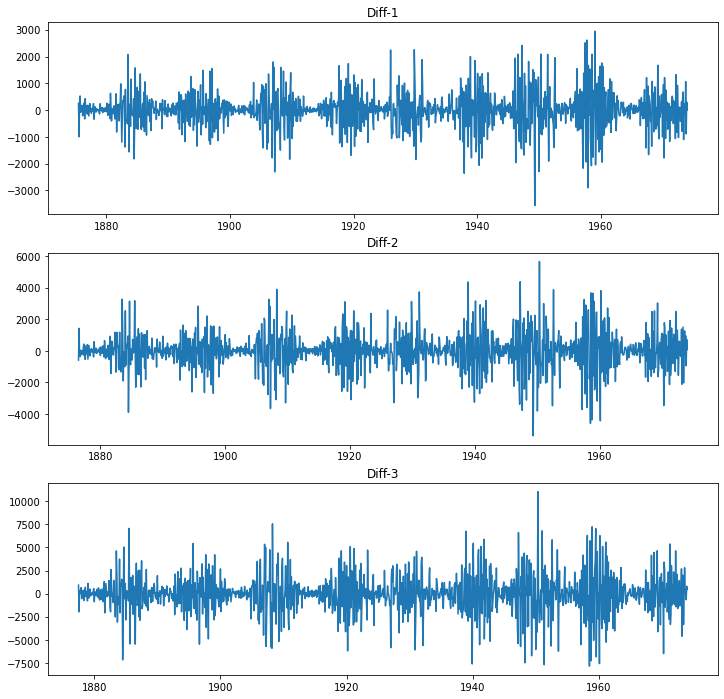

In [204]:
from statsmodels.tsa.statespace.tools import diff 

plt.figure(figsize = (12, 12))
for i in range(1,4):
    diff_data = diff(train, seasonal_periods=12, k_seasonal_diff=i)
    plt.subplot(3,1,i)
    plt.title("Diff-"+str(i))
    plt.plot(diff_data)

Lets re-plot ACF/PACF plots for diff-1 data. It seems present vlaues no longer correlate with historical values. From the plots below, it suggests **P, Q** could be 5 and 2.

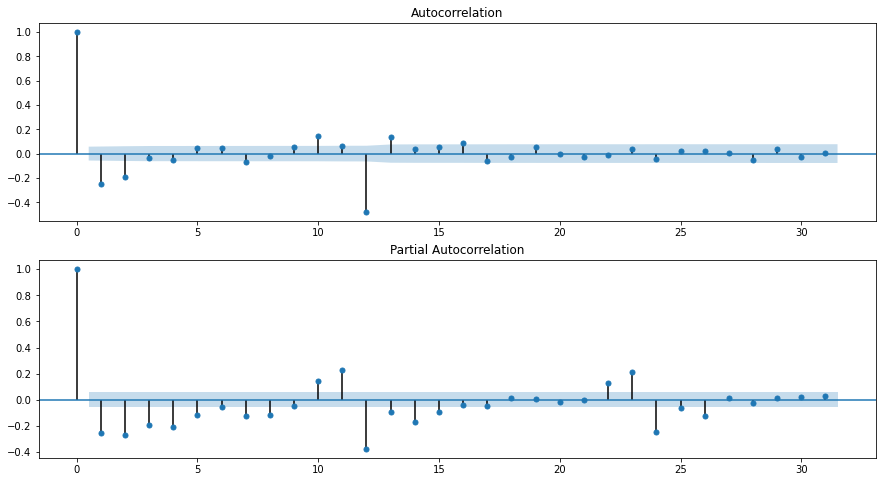

In [203]:
#ACF and PACF for seaosonal Diff-1
from statsmodels.tsa.statespace.tools import diff 
diff_data = diff(train, seasonal_periods=12, k_seasonal_diff=1)
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
fig = plt.figure(figsize = (15, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(diff_data.values.squeeze(), ax = ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(diff_data,  ax=ax2)

### 6.2 Model Training

Seasonal ARIMA is relatively challenging to pick parameters just by observing AFC/PACF plots. I will create a interation process to pick the best order. The Akaike information criterion (AIC) is an estimator of out-of-sample prediction error and thereby relative quality of statistical models for a given set of data. In ARIMA model, AIC is the primary indictaor whether this model is good or not.

In [60]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

def RMSE(y, y_pred):
    from sklearn.metrics import mean_squared_error
    from math import sqrt
    return round((sqrt(mean_squared_error(y, y_pred))), ndigits =2)

record = []
from datetime import datetime
start = datetime.now()
for p in range(0,2):
    for q in range(0,2):
        for d in range(0,2):
            for P in range (0,6):
                for D in range(0,2):
                    for Q in range(0,6):
                        try:
                            model = SARIMAX(train, order=(p,d,q), seasonal_order = (Q,D,Q,12)).fit()
                            pred = model.forecast(steps = len(test))
                            y = {
                                "p": p,
                                "d": d,
                                "q": q,
                                "P": P,
                                "D": D,
                                "Q": Q,
                                "AIC": round(model.aic)
                            }
                            print(y)
                            record.append(y)
                        except:
                            pass
print("Modeling Process Took: ",datetime.now() - start)
        

{'p': 0, 'd': 0, 'q': 0, 'P': 0, 'D': 0, 'Q': 0, 'AIC': 20242.0, 'RMSE': 1268.71}
{'p': 0, 'd': 0, 'q': 0, 'P': 0, 'D': 0, 'Q': 1, 'AIC': 19034.0, 'RMSE': 1242.92}
{'p': 0, 'd': 0, 'q': 0, 'P': 0, 'D': 0, 'Q': 2, 'AIC': 19012.0, 'RMSE': 1267.74}
{'p': 0, 'd': 0, 'q': 0, 'P': 0, 'D': 0, 'Q': 3, 'AIC': 18622.0, 'RMSE': 738.43}
{'p': 0, 'd': 0, 'q': 0, 'P': 0, 'D': 0, 'Q': 4, 'AIC': 18618.0, 'RMSE': 710.34}
{'p': 0, 'd': 0, 'q': 0, 'P': 0, 'D': 0, 'Q': 5, 'AIC': 18619.0, 'RMSE': 709.31}
{'p': 0, 'd': 0, 'q': 0, 'P': 0, 'D': 1, 'Q': 0, 'AIC': 18962.0, 'RMSE': 1011.15}
{'p': 0, 'd': 0, 'q': 0, 'P': 0, 'D': 1, 'Q': 1, 'AIC': 18748.0, 'RMSE': 862.54}
{'p': 0, 'd': 0, 'q': 0, 'P': 0, 'D': 1, 'Q': 2, 'AIC': 18750.0, 'RMSE': 862.71}
{'p': 0, 'd': 0, 'q': 0, 'P': 0, 'D': 1, 'Q': 3, 'AIC': 18401.0, 'RMSE': 801.38}
{'p': 0, 'd': 0, 'q': 0, 'P': 0, 'D': 1, 'Q': 4, 'AIC': 18419.0, 'RMSE': 720.38}
{'p': 0, 'd': 0, 'q': 0, 'P': 0, 'D': 1, 'Q': 5, 'AIC': 18431.0, 'RMSE': 744.21}
{'p': 0, 'd': 0, 'q': 0,

{'p': 0, 'd': 1, 'q': 0, 'P': 2, 'D': 0, 'Q': 5, 'AIC': 18117.0, 'RMSE': 1012.05}
{'p': 0, 'd': 1, 'q': 0, 'P': 2, 'D': 1, 'Q': 0, 'AIC': 18789.0, 'RMSE': 8168.94}
{'p': 0, 'd': 1, 'q': 0, 'P': 2, 'D': 1, 'Q': 1, 'AIC': 17996.0, 'RMSE': 1105.41}
{'p': 0, 'd': 1, 'q': 0, 'P': 2, 'D': 1, 'Q': 2, 'AIC': 17999.0, 'RMSE': 1097.74}
{'p': 0, 'd': 1, 'q': 0, 'P': 2, 'D': 1, 'Q': 3, 'AIC': 18015.0, 'RMSE': 1131.67}
{'p': 0, 'd': 1, 'q': 0, 'P': 2, 'D': 1, 'Q': 4, 'AIC': 18020.0, 'RMSE': 1110.44}
{'p': 0, 'd': 1, 'q': 0, 'P': 2, 'D': 1, 'Q': 5, 'AIC': 18023.0, 'RMSE': 1071.97}
{'p': 0, 'd': 1, 'q': 0, 'P': 3, 'D': 0, 'Q': 0, 'AIC': 18113.0, 'RMSE': 1098.72}
{'p': 0, 'd': 1, 'q': 0, 'P': 3, 'D': 0, 'Q': 1, 'AIC': 18107.0, 'RMSE': 966.24}
{'p': 0, 'd': 1, 'q': 0, 'P': 3, 'D': 0, 'Q': 2, 'AIC': 18114.0, 'RMSE': 1070.28}
{'p': 0, 'd': 1, 'q': 0, 'P': 3, 'D': 0, 'Q': 3, 'AIC': 18116.0, 'RMSE': 1068.08}
{'p': 0, 'd': 1, 'q': 0, 'P': 3, 'D': 0, 'Q': 4, 'AIC': 18114.0, 'RMSE': 966.99}
{'p': 0, 'd': 1, '

{'p': 0, 'd': 0, 'q': 1, 'P': 5, 'D': 1, 'Q': 4, 'AIC': 18151.0, 'RMSE': 680.59}
{'p': 0, 'd': 0, 'q': 1, 'P': 5, 'D': 1, 'Q': 5, 'AIC': 18216.0, 'RMSE': 751.82}
{'p': 0, 'd': 1, 'q': 1, 'P': 0, 'D': 0, 'Q': 0, 'AIC': 17915.0, 'RMSE': 1051.16}
{'p': 0, 'd': 1, 'q': 1, 'P': 0, 'D': 0, 'Q': 1, 'AIC': 17907.0, 'RMSE': 947.51}
{'p': 0, 'd': 1, 'q': 1, 'P': 0, 'D': 0, 'Q': 2, 'AIC': 17917.0, 'RMSE': 1032.45}
{'p': 0, 'd': 1, 'q': 1, 'P': 0, 'D': 0, 'Q': 3, 'AIC': 17918.0, 'RMSE': 991.7}
{'p': 0, 'd': 1, 'q': 1, 'P': 0, 'D': 0, 'Q': 4, 'AIC': 17910.0, 'RMSE': 951.59}
{'p': 0, 'd': 1, 'q': 1, 'P': 0, 'D': 0, 'Q': 5, 'AIC': 17911.0, 'RMSE': 949.37}
{'p': 0, 'd': 1, 'q': 1, 'P': 0, 'D': 1, 'Q': 0, 'AIC': 18590.0, 'RMSE': 9555.05}
{'p': 0, 'd': 1, 'q': 1, 'P': 0, 'D': 1, 'Q': 1, 'AIC': 17799.0, 'RMSE': 1057.2}
{'p': 0, 'd': 1, 'q': 1, 'P': 0, 'D': 1, 'Q': 2, 'AIC': 17802.0, 'RMSE': 1045.21}
{'p': 0, 'd': 1, 'q': 1, 'P': 0, 'D': 1, 'Q': 3, 'AIC': 17807.0, 'RMSE': 1056.79}
{'p': 0, 'd': 1, 'q': 1,

{'p': 1, 'd': 0, 'q': 0, 'P': 2, 'D': 0, 'Q': 3, 'AIC': 18067.0, 'RMSE': 895.42}
{'p': 1, 'd': 0, 'q': 0, 'P': 2, 'D': 0, 'Q': 4, 'AIC': 18071.0, 'RMSE': 884.22}
{'p': 1, 'd': 0, 'q': 0, 'P': 2, 'D': 0, 'Q': 5, 'AIC': 18071.0, 'RMSE': 896.93}
{'p': 1, 'd': 0, 'q': 0, 'P': 2, 'D': 1, 'Q': 0, 'AIC': 18514.0, 'RMSE': 1026.78}
{'p': 1, 'd': 0, 'q': 0, 'P': 2, 'D': 1, 'Q': 1, 'AIC': 17910.0, 'RMSE': 876.73}
{'p': 1, 'd': 0, 'q': 0, 'P': 2, 'D': 1, 'Q': 2, 'AIC': 17908.0, 'RMSE': 939.54}
{'p': 1, 'd': 0, 'q': 0, 'P': 2, 'D': 1, 'Q': 3, 'AIC': 17920.0, 'RMSE': 876.56}
{'p': 1, 'd': 0, 'q': 0, 'P': 2, 'D': 1, 'Q': 4, 'AIC': 18061.0, 'RMSE': 866.08}
{'p': 1, 'd': 0, 'q': 0, 'P': 2, 'D': 1, 'Q': 5, 'AIC': 18045.0, 'RMSE': 689.44}
{'p': 1, 'd': 0, 'q': 0, 'P': 3, 'D': 0, 'Q': 0, 'AIC': 18079.0, 'RMSE': 1267.63}
{'p': 1, 'd': 0, 'q': 0, 'P': 3, 'D': 0, 'Q': 1, 'AIC': 18065.0, 'RMSE': 894.47}
{'p': 1, 'd': 0, 'q': 0, 'P': 3, 'D': 0, 'Q': 2, 'AIC': 18068.0, 'RMSE': 899.75}
{'p': 1, 'd': 0, 'q': 0, '

{'p': 1, 'd': 1, 'q': 0, 'P': 5, 'D': 0, 'Q': 1, 'AIC': 18013.0, 'RMSE': 967.24}
{'p': 1, 'd': 1, 'q': 0, 'P': 5, 'D': 0, 'Q': 2, 'AIC': 18020.0, 'RMSE': 1077.47}
{'p': 1, 'd': 1, 'q': 0, 'P': 5, 'D': 0, 'Q': 3, 'AIC': 18017.0, 'RMSE': 1040.28}
{'p': 1, 'd': 1, 'q': 0, 'P': 5, 'D': 0, 'Q': 4, 'AIC': 18021.0, 'RMSE': 1004.96}
{'p': 1, 'd': 1, 'q': 0, 'P': 5, 'D': 0, 'Q': 5, 'AIC': 18015.0, 'RMSE': 979.74}
{'p': 1, 'd': 1, 'q': 0, 'P': 5, 'D': 1, 'Q': 0, 'AIC': 18712.0, 'RMSE': 8179.02}
{'p': 1, 'd': 1, 'q': 0, 'P': 5, 'D': 1, 'Q': 1, 'AIC': 17903.0, 'RMSE': 1099.61}
{'p': 1, 'd': 1, 'q': 0, 'P': 5, 'D': 1, 'Q': 2, 'AIC': 17903.0, 'RMSE': 1072.7}
{'p': 1, 'd': 1, 'q': 0, 'P': 5, 'D': 1, 'Q': 3, 'AIC': 18007.0, 'RMSE': 1028.91}
{'p': 1, 'd': 1, 'q': 0, 'P': 5, 'D': 1, 'Q': 5, 'AIC': 18154.0, 'RMSE': 1404.46}
{'p': 1, 'd': 0, 'q': 1, 'P': 0, 'D': 0, 'Q': 0, 'AIC': 17923.0, 'RMSE': 1245.93}
{'p': 1, 'd': 0, 'q': 1, 'P': 0, 'D': 0, 'Q': 1, 'AIC': 17921.0, 'RMSE': 1310.22}
{'p': 1, 'd': 0, 'q

{'p': 1, 'd': 1, 'q': 1, 'P': 2, 'D': 0, 'Q': 1, 'AIC': 17869.0, 'RMSE': 1019.43}
{'p': 1, 'd': 1, 'q': 1, 'P': 2, 'D': 0, 'Q': 2, 'AIC': 17868.0, 'RMSE': 1004.16}
{'p': 1, 'd': 1, 'q': 1, 'P': 2, 'D': 0, 'Q': 3, 'AIC': 17862.0, 'RMSE': 922.53}
{'p': 1, 'd': 1, 'q': 1, 'P': 2, 'D': 0, 'Q': 4, 'AIC': 17860.0, 'RMSE': 918.24}
{'p': 1, 'd': 1, 'q': 1, 'P': 2, 'D': 0, 'Q': 5, 'AIC': 17861.0, 'RMSE': 916.81}
{'p': 1, 'd': 1, 'q': 1, 'P': 2, 'D': 1, 'Q': 0, 'AIC': 18487.0, 'RMSE': 9384.48}
{'p': 1, 'd': 1, 'q': 1, 'P': 2, 'D': 1, 'Q': 1, 'AIC': 17749.0, 'RMSE': 1026.45}
{'p': 1, 'd': 1, 'q': 1, 'P': 2, 'D': 1, 'Q': 2, 'AIC': 17753.0, 'RMSE': 1022.23}
{'p': 1, 'd': 1, 'q': 1, 'P': 2, 'D': 1, 'Q': 3, 'AIC': 17757.0, 'RMSE': 1014.28}
{'p': 1, 'd': 1, 'q': 1, 'P': 2, 'D': 1, 'Q': 4, 'AIC': 17844.0, 'RMSE': 999.78}
{'p': 1, 'd': 1, 'q': 1, 'P': 2, 'D': 1, 'Q': 5, 'AIC': 18017.0, 'RMSE': 1319.91}
{'p': 1, 'd': 1, 'q': 1, 'P': 3, 'D': 0, 'Q': 0, 'AIC': 17863.0, 'RMSE': 1019.26}
{'p': 1, 'd': 1, 'q'

The modeling process took over 7 hours which are very time-consuming. I created a quick table to compare AIC and RMSE of different parameters. I checked Top-10 and figure out most of them have decent RMSE scores (somewhat better than **ETS Model**) but it seems that (1,1,1)(5,1,1) is a great candidate.

In [213]:
pd.DataFrame(record).sort_values('AIC').head(10).drop(columns=['RMSE'])

,p,d,q,P,D,Q,AIC
511,1,1,1,2,1,1,17749.0
547,1,1,1,5,1,1,17749.0
499,1,1,1,1,1,1,17749.0
535,1,1,1,4,1,1,17749.0
523,1,1,1,3,1,1,17749.0
487,1,1,1,0,1,1,17749.0
512,1,1,1,2,1,2,17753.0
524,1,1,1,3,1,2,17753.0
500,1,1,1,1,1,2,17753.0
536,1,1,1,4,1,2,17753.0


In [214]:
#train the model based on the selection
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train, order=(1,1,1), seasonal_order=(5,1,1,12)).fit()

In [215]:
print(model.aic, model.bic, model.hqic)
print(model.params)

17749.26426970801 17794.946549483815 17766.48454146106
ar.L1            0.315308
ma.L1           -0.780908
ar.S.L12         0.005111
ar.S.L24        -0.036468
ar.S.L36        -0.012660
ar.S.L48         0.018091
ar.S.L60        -0.069865
ma.S.L12        -0.999504
sigma2      180817.750774
dtype: float64


### 6.3 Model Diagositics
From the diagosticts plot, it seems overally this model has good performance and the residual is normal distributed. However, this model may be underperforming at peak or bottom. This is under expecation as ARIMA is usually not good at forecasting something that is not stationary.

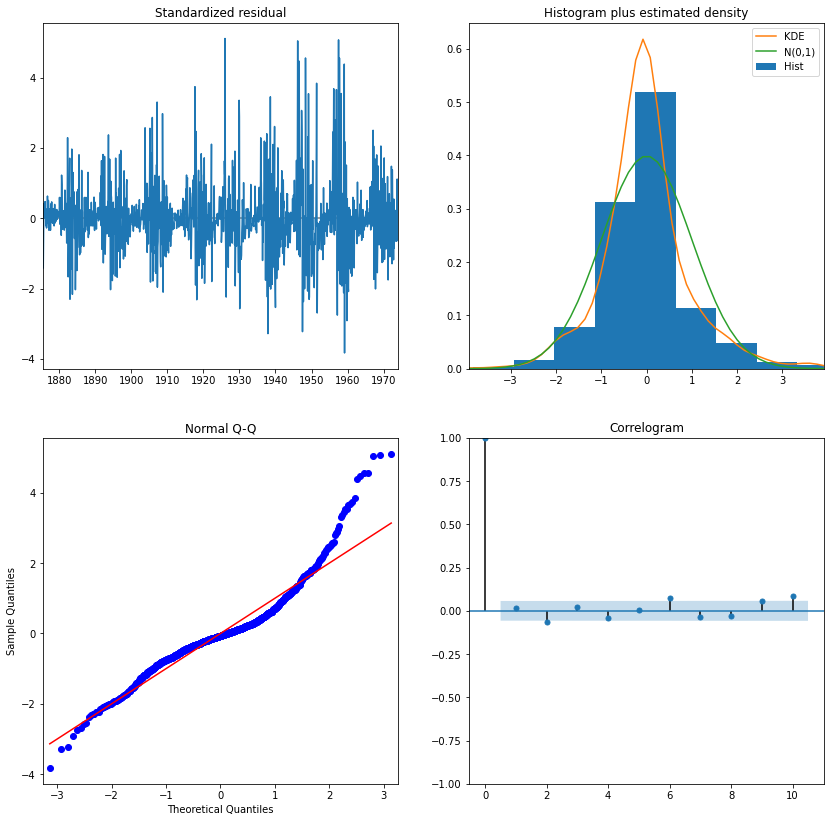

In [216]:
model.plot_diagnostics(figsize=(14, 14))
plt.show()

###  6.4 ARIMA Prediction

In [217]:
sarima_pred = model.forecast(steps = len(test))

## 7. LSTM Network <a class="anchor" id="7"></a>

Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. They were introduced by **Hochreiter & Schmidhuber (1997)**, and were refined and popularized by many people in following work. They work tremendously well on a large variety of problems, and are now widely used. 

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" width="600" height="200">

The benefits of LSTM network are：
- Forget unrelated patterns in the past
- Not relying on linear pattern, which happens to be the drawbacks for tradtional methods like ARIMA and ETS

To be able to run deep learning network, we have to convert time series data into supervised learning data. Also, the pre-processing is required as the activation function of LSTM needs data between -1 and 1. 

### 7.1 LSTM Pre-Processing

In [98]:
# transfer series into supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
    from sklearn.preprocessing import MinMaxScaler
    # extract raw values
    raw_values = series.values
    # transform data to be stationary
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test

#pick time parameters
n_test = len(test) #round(len(test))
n_lag = 12
n_seq = 3

# prepare data
scaler, train_lstm, test_lstm = prepare_data(train, n_test, n_lag, n_seq)
print(test_lstm)
print('Train: %s, Test: %s' % (train_lstm.shape, test_lstm.shape))

[[-0.13238932  0.05126674  0.02217862 ...  0.33250874 -0.0478973
   0.01125992]
 [ 0.05126674  0.02217862  0.03241491 ... -0.0478973   0.01125992
   0.00298558]
 [ 0.02217862  0.03241491 -0.02746737 ...  0.01125992  0.00298558
   0.01454406]
 ...
 [ 0.11503028 -0.12786829  0.23867611 ...  0.05450823  0.32773181
  -0.14040775]
 [-0.12786829  0.23867611 -0.13435128 ...  0.32773181 -0.14040775
  -0.00733601]
 [ 0.23867611 -0.13435128  0.06568285 ... -0.14040775 -0.00733601
   0.06653587]]
Train: (668, 15), Test: (513, 15)


### 7.2 Create 5-Layer LSTM Network and Fit the Model

In [176]:
# fit an LSTM network to training data
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(0.1))
    model.add(Dense(y.shape[1]))
    model.add(Dropout(0.1))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

#determine epochs, batches, and neuron size 
n_epochs = 100
n_batch = 1
n_neurons = 3

# fit model
from datetime import datetime
start = datetime.now()
model_lstm = fit_lstm(train_lstm, n_lag, n_seq, n_batch, n_epochs, n_neurons)
print("Modeling Process Took: ",datetime.now() - start)

Modeling Process Took:  0:01:29.867868


In [172]:
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = np.array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
 
# invert differenced forecast
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

# evaluate the RMSE for each forecast time step
from sklearn.metrics import mean_squared_error
from math import sqrt
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = RMSE(actual, predicted)
        print('t+%d RMSE: %.2f' % ((i+1), rmse))

# make forecasts
forecasts = make_forecasts(model_lstm, n_batch, train_lstm, test_lstm, n_lag, n_seq)
# inverse transform forecasts and test
forecasts = inverse_transform(train, forecasts, scaler, len(test))
actual = [row[n_lag:] for row in test_lstm]
actual = inverse_transform(train, actual, scaler, len(test))
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

t+1 RMSE: 556.56
t+2 RMSE: 648.86
t+3 RMSE: 694.31


### 7.3 LSTM Forecast 

It seems 1-lag has the best prediction so that we will go ahead with this one.

In [173]:
lstm_pred = [x[0] for x in forecasts]

## 8. Model Performance <a class="anchor" id="8"></a>

Plot the forecasts together with actual data. Meanwhile, the RMSE scores and tuning time are visualized as below. 

In summary, LSTM network is `much better on predicting the trends`, `saving tons of tuning time`, and `improving forecasting accuracy`.

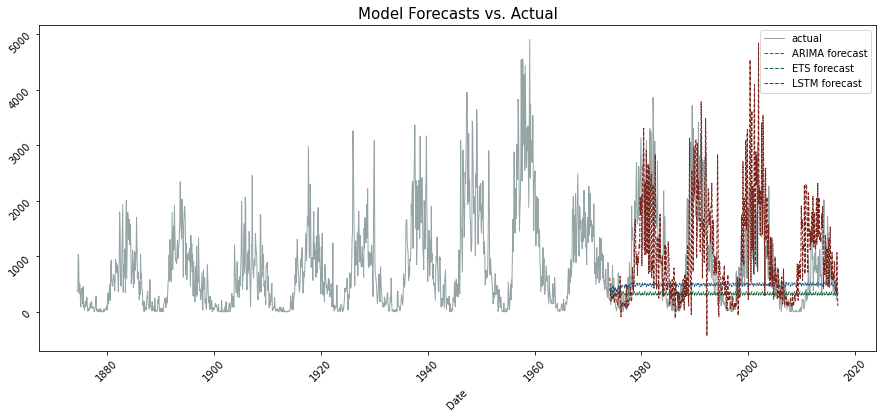

In [221]:
fig = plt.figure(figsize=(15,6))
plt.plot(data, color= '#95A5A6', linewidth = 1, label = "actual")
plt.plot(sarima_pred, color= '#21618C', linewidth = 1, 
        linestyle='dashed', label = "ARIMA forecast")
plt.plot(ETS_pred, color= '#186A3B', linewidth = 1, 
        linestyle='dashed', label = "ETS forecast")
plt.plot(test.index,lstm_pred, color= '#7B241C', linewidth = 1, 
        linestyle='dashed', label = "LSTM forecast")
plt.xlabel("Date", rotation=45)
plt.xticks(rotation=45)
plt.ylabel("")
plt.yticks(rotation=45)
plt.title("Model Forecasts vs. Actual", fontsize = 15)
plt.legend()
plt.show()

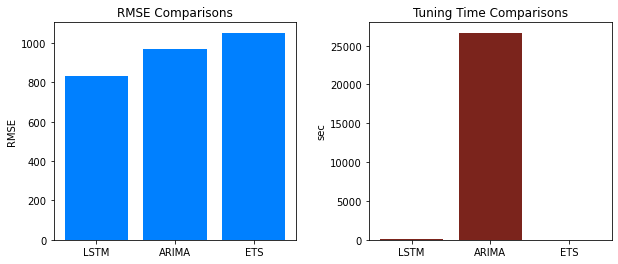

In [219]:
fig = plt.figure(figsize=(10,4))
plt.subplots_adjust(wspace=0.3)

ax1 = fig.add_subplot(121)
r = [RMSE(test,lstm_pred), RMSE(test, sarima_pred), RMSE(test, ETS_pred)]
plt.title("RMSE Comparisons")
labels = ['LSTM', 'ARIMA', 'ETS']
plt.ylabel('RMSE')
plt.bar(labels, r, color = '#0080ff')

ax2 = fig.add_subplot(122)
time = [40.413523, 7*3600+24*60+27.265485, 00.248902 ]
plt.title("Tuning Time Comparisons")
plt.ylabel('sec')
plt.bar(labels, time, color = '#7B241C')

plt.show()

## 9. References <a class="anchor" id="9"></a>

- <a href="https://solarscience.msfc.nasa.gov/greenwch.shtml"> NASA, 2017, Royal Observatory, Greenwich - USAF/NOAA Sunspot Data
- <a href="https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/"> Brownlee, J , 2017, Multi-step Time Series Forecasting with Long Short-Term Memory Networks in Python</a>
- <a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/">colah's blog, 2015, Understanding LSTM Networks</a>
- <a href="https://en.wikipedia.org/wiki/Long_short-term_memory">Wiki, 2020, Long short-term memory</a>
- <a href="https://en.wikipedia.org/wiki/Akaike_information_criterion">Wiki, 2020, Akaike information criterion</a>
- <a href="https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average">Wiki, 2020, Autoregressive integrated moving average</a>
- <a href="https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test">Wiki, 2020, Augmented Dickey–Fuller test</a>
- <a href="https://doi.org/10.1287/mnsc.31.10.1237"> Gardner, E. S., & McKenzie, E. , 1985, Forecasting trends in time series. *Management Science*, 31(10), 1237–1246</a>
- <a href="https://otexts.com/fpp2/">Hyndman, R.J., & Athanasopoulos, G., 2018, Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia.</a>
- <a href="https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8">Salvi, J
, 2019, Significance of ACF and PACF Plots In Time Series Analysis</a>
- <a href="https://doi.org/10.1016/0304-4076(92)90104-Y">Kwiatkowski, D., Phillips, P. C. B., Schmidt, P., & Shin, Y. , 1992, Testing the null hypothesis of stationarity against the alternative of a unit root: How sure are we that economic time series have a unit root? *Journal of Econometrics*, 54(1-3), 159–178. </a>
